# OpenFE Showcase : Relative Binding Free Energy calculation of T4 lysozyme ligand using OpenMM

This notebook demonstrates the current capabilities of the OpenFE toolkit. Here
we specifically look at how relative binding free energy calculations can be
carried out using the OpenMM MD engine in combination with the OpenFE toolset.
This notebook will be continually updated as OpenFE introduces new features.

## 1. Overview

### Relative binding free energies of small ligands complexed to T4-lysozyme L99A mutant

In this example we look how one could set up a network of transformations using
the OpenFE toolkit for small chemical modifications of an initial known
binder, benzene, to T4-lysozyme L99A.

Crystallographic and affinity data (dG of -5.2 kcal/mol) are available for
benzene and demonstrate the ligand to bind within the lipophylic cavity of
T4-lysozyme L99A.

In [ ]:
# Let's visualise the known protein-ligand complex
# We use MDAnalysis to fetch the 181L complex and nglview to visualise it
import MDAnalysis as mda
import nglview as nv

u = mda.fetch_mmtf('181L')
view = nv.show_mdanalysis(u)
view.display()
view

For convenience, a prepared (capped and protonated) PDB structure of the
T4-lysozyme L994A protein is provided under `inputs/181L_mod_capped_protonated.pdb`.

### Alchemical transformations of benzene

Chemical modifications benzene binding to T4 lysozyme are relatively well
studied, examples can be seen in the works of [Mobley et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2104542/) and [Gapsys et al.](https://www.nature.com/articles/s42004-021-00498-y#Fig1). Here we explore how OpenFE can be used
to build a simple star map network for planned alchemical substitutions of the
core benzene ring.

Five pre-aligned compounds (phenol, toluene, anisole, styrene, benzonitrile,
and benzaldehyde) and the benzene core are available under
`inputs/ligands.sdf`. These are shown in the cell below.

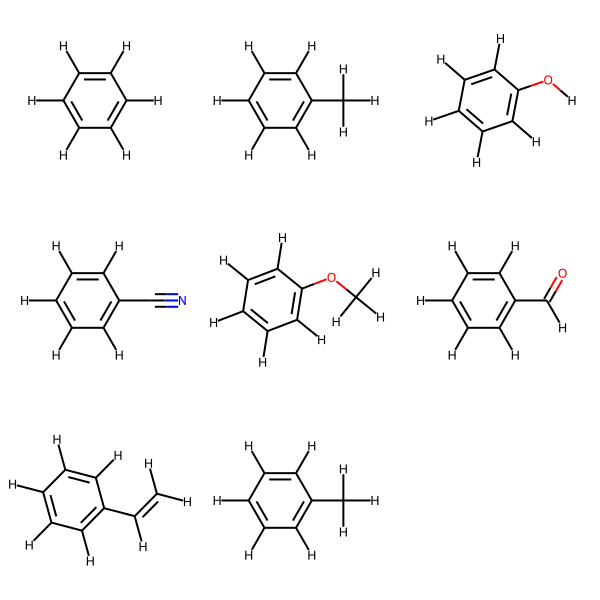

In [1]:
# Let's have a look at our ligands

from rdkit import Chem
from rdkit.Chem import AllChem

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol)

Ultimately we will limit the RBFEs done in this notebook to the transformation
of benzene to phenol, as similarly done in the [AMBER free energy tutorial](https://ambermd.org/tutorials/advanced/tutorial9/index.html#home). Previous work has
shown that phenol does not bind to T4-Lysozyme L99A, so we expect that the RBFE
will capture the positive change in the free energy.

### The plan

Here is what we will achieve in this notebook and what software toolchains are
used along the way.

| **Actions**                    | **Software**                          |
|:------------------------------:|:-------------------------------------:|
| Create OpenFE Molecules        | OpenFE tk, RDKit                      |
| Create Radial Network          | OpenFE tk, Lomap, Networkx            |
| Visualise Netwwork             | OpenFE tk, NetworkX, RDKit, Cyjupyter | 
| Create ligand topologies       | OpenFF tk                             |
| Create hybrid OpenMM topology  | OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenMMTools (eventually - ex Perses)  |
| Setup and run RBFE calculation | OpenMM + OpenMMTools                  |
| Analysis RBFE calculation      | PyMBAR + OpenMMTools                  |

## 2. Creating a transformation network

### Creating OpenFE Molecules

In order to keep track of the various ligands being passed through the OpenFE
toolkit, OpenFE implements a basic [Molecule class](https://github.com/OpenFreeEnergy/openfe/blob/main/openfe/setup/molecule.py)
which takes in and stores [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html).

In the backend, OpenFE treats the RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example OpenEye's OEMol).

Here we demonstrate how to load the ligands from `inputs/ligands.sdf` into a
list of OpenFE Molecules for further processing.

In [139]:
from openfe.setup import Molecule

# Create and SDF supplier
# Extract the contents of the sdf file and visualise it
ligands_sdf = Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=True)

# Now pass these to form a list of Moelcules
ligand_mols = [Molecule(sdf) for sdf in ligands_sdf]

### Creating a network

From these molecules we can quickly create a star map network which centers
around the first ligand in our sdf file (benzene) using
`openfe.setup.network_planning.generate_radial_network`.

Here we use Lomap (via the OpenFE interface LomapAtomMapper) to define the atom mappings between the various ligands and the central benzene structure. Whilst
we use the defaults here, please note that the various supported arguments of
Lomap can be passed to LomapAtomMapper.

Note: LomapAtomMapper is currently the only implemented Mapper in OpenFE,
however in future work we will look to implement various other ones, such as
the rjmc mapper from Perses. Long term, users will be able to pass serveral
mappers and atom mapping scoring methods on network generation.

In [140]:
# Create network from the two molecules
from openfe.setup.network_planning import generate_radial_network
from openfe.setup.lomap_mapper import LomapAtomMapper

# ligand_mols[1:] are the substituted ligands
# ligand_mols[0] is the benzene

network = generate_radial_network(ligands=ligand_mols[1:],
                                  central_ligand=ligand_mols[0],
                                  mappers=[LomapAtomMapper(threed=True, max3d=0),])

In [141]:
from lomap import MCS

In [142]:
ligand_mols[1]._rdkit.GetProp('_Name')

'toluene'

In [143]:
mcs = MCS(ligand_mols[0]._rdkit, ligand_mols[1]._rdkit)
mapping = [m for m in mcs.getMapping(ligand_mols[0]._rdkit, ligand_mols[1]._rdkit)]
print(mapping)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]


In [135]:
mcs.heavy_atom_mcs_map()

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

In [136]:
def get_attached_atoms_not_in_mcs(mol,i):
    ''' Get atoms attached to atom i which are not in the MCS '''
    attached=[]
    for b in mol.GetBonds():
        if (b.GetEndAtomIdx() == i) or (b.GetBeginAtomIdx() == i):
            j = b.GetEndAtomIdx()
            if (j==i):
                j=b.GetBeginAtomIdx()
            # OK, so j is the atom at the other end of the bond atom atom i. Is it in the MCS?
            inMCS = mol.GetAtomWithIdx(j).HasProp('to_mcs')
            if not inMCS:
                attached.append(j)
    return attached

maplist = mcs.heavy_atom_mcs_map()

for at in mcs.mcs_mol.GetAtoms():
    moli = mcs.moli
    molj = mcs.molj
    idx1 = int(at.GetProp("to_moli"))
    idx2 = int(at.GetProp("to_molj"))
    print(idx1, idx2)
    attached_i = get_attached_atoms_not_in_mcs(mcs.moli, idx1)
    attached_j = get_attached_atoms_not_in_mcs(mcs.molj, idx2)            
    print(missingi)
    print(missingj)
    

    while attached_i and attached_j:

        hidx_i=-1
        hidx_j=-1
        best_dist=2
        for ai in attached_i:
            if moli.GetAtomWithIdx(ai).GetAtomicNum()==1:
                for aj in attached_j:
                    if molj.GetAtomWithIdx(aj).GetAtomicNum()==1:
                        print("aj", aj)
                        dist = (moli.GetConformer().GetAtomPosition(ai)
                                - molj.GetConformer().GetAtomPosition(aj)).Length()
                        print(dist)
                        if (dist < best_dist):
                            hidx_i=ai
                            hidx_j=aj
                            best_dist=dist
                            print("hmapped:", hidx_j, hidx_i)
        if (hidx_i<0):
            # OK, no hydrogen-hydrogen matches left. Try to match a hydrogen to a non-hydrogen
            for ai in attached_i:
                for aj in attached_j:
                    if moli.GetAtomWithIdx(ai).GetAtomicNum()==1 or molj.GetAtomWithIdx(aj).GetAtomicNum()==1:
                        dist = (moli.GetConformer().GetAtomPosition(ai)
                                - molj.GetConformer().GetAtomPosition(aj)).Length()
                        print(dist)
                        if (dist < best_dist):
                            hidx_i=ai
                            hidx_j=aj
                            best_dist=dist

        if (hidx_i>=0):
            # Found a mappable pair: add and try again
            maplist.append((hidx_i,hidx_j))
            attached_i.remove(hidx_i)
            attached_j.remove(hidx_j)
        else:
            break   # No mappable pairs left

0 1
[6]
[]
1 2
[6]
[]
2 3
[6]
[]
3 4
[6]
[]
4 5
[6]
[]
5 6
[6]
[]


In [137]:
maplist

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

In [144]:
edges = [edge for edge in network.edges]
edges[0].mol2._rdkit.GetProp('_Name')

'styrene'

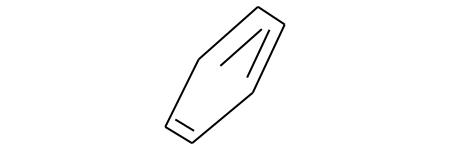

In [48]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

m = ligand_mols[0].to_rdkit()
m2 = AllChem.RemoveHs(m)
m2

This network contains a set of 6 edges centered around the benzene molecule
which define the various atom mappings between the the transformation pairs.

We can visualise this network using the `Cyjupyter` convenience method provided
in `utils/visualization.py` (note: at this moment we do not plan to add this to
the OpenFE toolkit, but may at a future date)

In [ ]:
from utils.visualization import draw_radial_network
draw_radial_network(network)

Edges along the network can be accessed to recover the invidual molecules
involved in that given alchemical tranformation, and the atom mapping between
the two molecules

In [ ]:
transform_edges = [edge for edge in network.edges]
print("molecule 1 smiles: ", transform_edges[0].mol1.smiles)
print("molecule 2 smiles: ", transform_edges[0].mol2.smiles)
print("map between molecule 1 and 2: ", transform_edges[0].mol1_to_mol2)

We can also visualise the atom mappings by invoking the individual OpenFE
AtomMapping objects directly.

Here we show two mappings for benzene -> phenol and benzene -> benzonitrile.

Unique atoms between each mapping are shown in red, and atoms which are mapped
but undergo element changes are shown in blue.

In [ ]:
## Wait for viz code to be merged into the main repo
## This will also demonstrate how edges can be access to gain the individual
## molecules and 

This is a rather simple atom mapping case. To show off the ability of the atom
mapping, here is a mapping generated via LomapMapper of the JNK1 dataset.

In [ ]:
## Todo once we have above done

### Storing the network

Once created a network can be stored to disk for..

TODO - add example of saving and loading a network

### The OpenFE CLI

Add example of mapping

TODO - we need to get viz up and running so that this has some good visual
impact. Probably can do the JNK1 set from above

## 3. Creating a hybrid OpenMM topology

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy differences along
an edge.

In order to simulate this transformation in OpenMM we opt for a single topology
approach (as also used in Perses). We therefore need to create a hybrid
topology which defines both endpoints of the transformation.

### Creating invidual ligand topologies and positions

We first start by using the OpenFF tk (which use the OpenFE Molecule
respresentation uses) to create an OpenMM topology and a set of positions.

In [ ]:
# First we extract the edge with the ligands of interest, here we look for the
# phenol which we will be transforming the benzene to
benz_to_phenol = [edge for edge in network.edges if
                  edge.mol2.to_rdkit().GetProp("_Name") == "phenol"][0]

# Next we extract the openff molecules for each ligand
benzene_off = benz_to_phenol.mol1.to_openff()
phenol_off = benz_to_phenol.mol2.to_openff()

# Set the residue names
benzene_off.name = 'benzene'
phenol_off.name = 'phenol'

# We can visualise phenol via the OFF tk
phenol_off

In [ ]:
# With these, we can now extract openmm topologies and positions for each ligand
benzene_top = benzene_off.to_topology()
benzene_pos = benzene_off.conformers[0]

phenol_top = phenol_off.to_topology()
phenol_pos = phenol_off.conformers[0]

### Setting our protein force field parameters and creating a protein modeller instance
Next we have to set up our parameters for the T4-lysozyme L99A protein we
will be using in the complex phases our of RBFE.

In [ ]:
import openmm
from openmm import app, unit
from openmm.app import PME, HBonds, PDBFile, Modeller

# Set force field parameters
omm_forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')

# Create protein system
prot_pdb = PDBFile('inputs/181L_mod_capped_protonated.pdb')
modeller = Modeller(prot_pdb.topology, prot_pdb.positions)

### Creating the "old" (benzene) OpenMM systems, topologies, and positions

Next to get us started towards hybrid systems we have to start by generating
the initial OpenMM objects defining the benzene system.

Note: from this point onwards we will define "old" as the initial benzene
endpoint, and "new" and the target phenol endpoint along the transformation.

First we create OpenMM system, topology, and positions for the benzene + T4
lysozyme complex:

In [ ]:
# Next we create an OpenMM System for the "old" (benzene) alchemical endstate
import numpy as np
from openmmforcefields.generators import SMIRNOFFTemplateGenerator

# first register an ommff generator with the required topology
smirnoff_benz = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[benzene_off])
omm_forcefield_benz = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield_benz.registerTemplateGenerator(smirnoff_benz.generator)

# Create Modeller object
old_modeller = Modeller(prot_pdb.topology, prot_pdb.positions)
old_modeller.add(benzene_top.to_openmm(), benzene_pos)

# Solvate the complex in a 0.15 mM cubic water box with 1.2 nm from the
# solute to the edges of the box
old_modeller.addSolvent(
    omm_forcefield_benz, model='tip3p', padding=1.2*unit.nanometer,
    ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions for "old" system
old_complex_system = omm_forcefield_benz.createSystem(
                         old_modeller.topology,
                         nonbondedMethod=PME,
                         nonbondedCutoff=0.9 * unit.nanometer,
                         constraints=HBonds,
                         rigidWater=True)


old_complex_topology = old_modeller.getTopology()

# We center the system by adding (30, 30, 30) [box is about 73 A per side]
old_complex_positions = old_modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

We also need to create OpenMM system, topology, and positions for the benzene
solely in water:

In [ ]:
# Next we create an OpenMM System for the "old" (benzene) alchemical endstate
import numpy as np
from openmmforcefields.generators import SMIRNOFFTemplateGenerator

# first register an ommff generator with the required topology
#smirnoff_benz = SMIRNOFFTemplateGenerator(
#    forcefield="openff-2.0.0.offxml", molecules=[benzene_off])
#omm_forcefield_benz = app.ForceField('amber99sb.xml', 'tip3p.xml')
#omm_forcefield_benz.registerTemplateGenerator(smirnoff_benz.generator)

# Create Modeller object
old_modeller = Modeller(benzene_top.to_openmm(), benzene_pos)

# Solvate the complex in a 0.15 mM cubic water box with 1.2 nm from the
# solute to the edges of the box
old_modeller.addSolvent(
    omm_forcefield_benz, model='tip3p', padding=1.2*unit.nanometer,
    ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions for "old" system
old_solvent_system = omm_forcefield_benz.createSystem(
                         old_modeller.topology,
                         nonbondedMethod=PME,
                         nonbondedCutoff=0.9 * unit.nanometer,
                         constraints=HBonds,
                         rigidWater=True)


old_solvent_topology = old_modeller.getTopology()

# We center the system by adding (14, 14, 14) [box is ~ 28.6 A per side]
old_solvent_positions = old_modeller.getPositions() + np.array([14, 14, 14]) * unit.angstrom

### Creating the "new" (phenol) OpenMM Topologies

From these initial objects defining the benzene system we can create "new"
Topologies defining the phenol system.

Here we use `append_new_topology` (which we hope to move to the main OpenFE
repository eventually), which removes the benzene molecule from the "old"
topology and grafts in the phenol molecule topology.

In [ ]:
from utils import topologyhelpers

# Essentially we remove the benzene residue from the old topology and graft
# in the new phenol residue
new_complex_topology = topologyhelpers.append_new_topology_item(
                           old_complex_topology, phenol_top.to_openmm(),
                           exclude_residue_name="benzene")

new_solvent_topology = topologyhelpers.append_new_topology_item(
                           old_solvent_topology, phenol_top.to_openmm(),
                           exclude_residue_name="benzene")

Once we have our Topology objects we can go ahead and create OpenMM Systems for
the "new" complex and solvated phases.

In [ ]:
# Create the "new" complex system
smirnoff_phenol = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[phenol_off])
omm_forcefield_phenol = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield_phenol.registerTemplateGenerator(smirnoff_phenol.generator)

new_complex_system = omm_forcefield_phenol.createSystem(
                         new_complex_topology,
                         nonbondedMethod=PME,
                         nonbondedCutoff=0.9 * unit.nanometer,
                         constraints=HBonds, rigidWater=True)

# And now the "new" solvent system
new_solvent_system = omm_forcefield_phenol.createSystem(
                         new_solvent_topology,
                         nonbondedMethod=PME,
                         nonbondedCutoff=0.9 * unit.nanometer,
                         constraints=HBonds, rigidWater=True)

### Generating mappings

Now that we have the two endstate systems for both the complex and solvent
phase, we have to define how the atoms between the two systems relate to each
other.

We start by using the mappings generated by LomapMapper above. We then use
`get_system_mappings` (which we also will eventually be moving to the OpenFE
tk) to shift the mappings by the protein & solvent atoms added to each systems.

todo - explain mappings?


In [ ]:
# Reminder: the mapping is stored in the edge benz_to_phenol

# Get mappings between the old and new complex systems
complex_mappings = topologyhelpers.get_system_mappings(benz_to_phenol.mol1_to_mol2,
                                                       old_complex_system,
                                                       old_complex_topology, "benzene",
                                                       new_complex_system,
                                                       new_complex_topology, "phenol",
                                                       fix_constraints=False,
                                                       remove_element_changes=True)

# And the mappings between the old and new solvent systems
solvent_mappings = topologyhelpers.get_system_mappings(benz_to_phenol.mol1_to_mol2,
                                                       old_solvent_system,
                                                       old_solvent_topology, "benzene",
                                                       new_solvent_system,
                                                       new_solvent_topology, "phenol",
                                                       fix_constraints=False,
                                                       remove_element_changes=True)

### Getting the new system positions

In order to ensure that we can properly transform between the two systems we
need to make sure that all mapped atoms have the same coordinates. To do this
we generate "new" coordinates based on those of the "old" systems.

This can be easily done using the mappings between systems obtained above.

Here `set_and_check_new_positions` copies over the positions of the old system,
removes the positions of the benzene and replaces them with those of the
phenol. We also check that all mapped atoms are within 1e-5 Angstroms of each
other.

In [ ]:
# Note we use shift_insert to make sure the phenol is shifted in the same
# way we did above to center the coordinates in the box.
new_complex_positions = topologyhelpers.set_and_check_new_positions(
                            complex_mappings, old_complex_topology,
                            new_complex_topology, old_complex_positions,
                            insert_positions=phenol_pos,
                            shift_insert=np.array([30, 30, 30]))

new_solvent_positions = topologyhelpers.set_and_check_new_positions(
                            solvent_mappings, old_solvent_topology,
                            new_solvent_topology, old_solvent_positions,
                            insert_positions=phenol_pos,
                            shift_insert=np.array([14, 14, 14]))


### Creating hybrid topology factories

Finally we create hybrid topology factories which gather the topology terms
from both the "old" and "new" systems to create the single topology "hybrid".

Note: HybridTopologyFactory is adapted from Perses, we hope to eventually
move it upstream to openmmtools.

In [ ]:
from utils import relative

hybrid_complex_factory = relative.HybridTopologyFactory(
                             old_complex_system, old_complex_positions,
                             old_complex_topology,
                             new_complex_system, new_complex_positions,
                             new_complex_topology,
                             old_to_new_atom_map=complex_mappings['old_to_new_atom_map'],
                             old_to_new_core_atom_map=complex_mappings['old_to_new_core_atom_map'],
                             use_dispersion_correction=False,
                             softcore_alpha=0.5,
                             softcore_LJ_v2=True,
                             softcore_LJ_v2_alpha=0.85,
                             softcore_electrostatics=True,
                             softcore_electrostatics_alpha=0.3,
                             softcore_sigma_Q=1.0,
                             interpolate_old_and_new_14s=False,
                             flatten_torsions=False,)

hybrid_solvent_factory = relative.HybridTopologyFactory(
                             old_solvent_system, old_solvent_positions,
                             old_solvent_topology,
                             new_solvent_system, new_solvent_positions,
                             new_solvent_topology,
                             old_to_new_atom_map=solvent_mappings['old_to_new_atom_map'],
                             old_to_new_core_atom_map=solvent_mappings['old_to_new_core_atom_map'],
                             use_dispersion_correction=False,
                             softcore_alpha=0.5,
                             softcore_LJ_v2=True,
                             softcore_LJ_v2_alpha=0.85,
                             softcore_electrostatics=True,
                             softcore_electrostatics_alpha=0.3,
                             softcore_sigma_Q=1.0,
                             interpolate_old_and_new_14s=False,
                             flatten_torsions=False,)

In [ ]:
# We'll also add barostats for later use
hybrid_complex_factory.hybrid_system.addForce(openmm.MonteCarloBarostat(1.0, 298.15, 50))

hybrid_solvent_factory.hybrid_system.addForce(openmm.MonteCarloBarostat(1.0, 298.15, 50))

## 4. Calculating RBFEs in OpenMM

With our single hybrid topologies generated, we can now move to creating
and running OpenMM simulations to sample the alchemical change.

Here we will be heavily using the replica exchange toolsets implemented in
openmmtools. In a future version of OpenFE we will switch this notebook to
demonstrate a simple "independent simulations per window" approach.

### Setting a Lambda protocol

We first start by defining the Lambda protocol which we will sample during our
simulation.

Here we use an adapted version of the LambdaProtocol class implemented in
Perses (which we hope we may get to move to openmmtools).

The default Lambda protcol used here, essentially amounts to the following:
1. Electrostatic and LJ terms of the "old" system are turned off between Lambdas 0.0 and 0.5
2. Electrostatic and LJ terms of the "new" system are turned on between Lambdas 0.5 and 1.0

We will run this Lambda protocol over 11 evenly spaced windows.

In [ ]:
from utils import lambdaprotocol
import matplotlib
%matplotlib inline

lambdas = lambdaprotocol.LambdaProtocol(functions="default", windows=11)

# Let's also plot the lambda function
lambdas.plot_functions()

### Setting our reporters

Next we set MultistateReporters which will track the system's positions and
energies during the simulations.

In [ ]:
# Next we set our multi state reporter
from openmmtools.multistate import MultiStateReporter

# Create a reporter for both the complex and solvent phases
selection_indices = hybrid_complex_factory.hybrid_topology.select('all')
complex_reporter = MultiStateReporter('complex-rbfe.nc',
                                      analysis_particle_indices=selection_indices,
                                      checkpoint_interval=100)

selection_indices = hybrid_solvent_factory.hybrid_topology.select('all')
solvent_reporter = MultiStateReporter('solvent-rbfe.nc',
                                      analysis_particle_indices=selection_indices,
                                      checkpoint_interval=100)

### Creating our samplers

We can next create Replica Exchange samplers for each of our phases.

Note: HybridRepexSampler is adapted from Perses. We are planning to move this
adapted tooling to openmmtools eventually.

In [ ]:
# First deal with the complex phase

# We Get the platform and context caches
from utils import compute
from openmmtools import mcmc, cache
from utils.multistate import HybridRepexSampler

platform = compute.get_openmm_platform()
comp_energy_context_cache = cache.ContextCache(capacity=None, time_to_live=None, 
                                               platform=platform)
comp_sampler_context_cache = cache.ContextCache(capacity=None, time_to_live=None,
                                                platform=platform)

# Then create the integrator - 2fs + 1 collion per ps, Swap every 5 ps
integrator = mcmc.LangevinSplittingDynamicsMove(
                 timestep=0.02 * unit.femtoseconds,
                 collision_rate=1.0 / unit.picosecond,
                 n_steps=2500,
                 reassign_velocities=True,
                 n_restart_attempts=20, constraint_tolerance=1e-06)

# Create sampler - see MultistateSampler for default options
# 11 HREX replicas at 298.15 K
complex_sampler = HybridRepexSampler(mcmc_moves=integrator,
                             hybrid_factory=hybrid_complex_factory)
complex_sampler.setup(reporter=complex_reporter, platform=platform,
                      lambda_protocol=lambdas,
                      temperature=298.15 * unit.kelvin, n_replicas=11,
                      endstates=False)

# Set the context caches
complex_sampler.energy_context_cache = comp_energy_context_cache
complex_sampler.sampler_context_cache = comp_sampler_context_cache

In [ ]:
# And now the solvent phase

# We get new context caches
solv_energy_context_cache = cache.ContextCache(capacity=None, time_to_live=None, 
                                               platform=platform)
solv_sampler_context_cache = cache.ContextCache(capacity=None, time_to_live=None,
                                                platform=platform)

# Then create the integrator - 2fs + 1 collion per ps, Swap every 5 ps
integrator = mcmc.LangevinSplittingDynamicsMove(
                 timestep=0.02 * unit.femtoseconds,
                 collision_rate=1.0 / unit.picosecond,
                 n_steps=2500,
                 reassign_velocities=True,
                 n_restart_attempts=20, constraint_tolerance=1e-06)

# Create sampler - see MultistateSampler for default options
# 11 HREX replicas at 298.15 K
solvent_sampler = HybridRepexSampler(mcmc_moves=integrator,
                                     hybrid_factory=hybrid_solvent_factory)
solvent_sampler.setup(reporter=solvent_reporter, platform=platform,
                      lambda_protocol=lambdas,
                      temperature=298.15 * unit.kelvin, n_replicas=11,
                      endstates=False)

# Set the context caches
solvent_sampler.energy_context_cache = solv_energy_context_cache
solvent_sampler.sampler_context_cache = solv_sampler_context_cache

### Running the simulations

Finally we can run our simulations.

Note: Due to the computational expense of this step we only do a short set of
simulations (1k steps minimisation, 1 * 5ps equilibration,
2 * 5 ps production). Ideally these should be _much_ longer.

In [ ]:
for i, sampler in enumerate([complex_sampler, solvent_sampler]):
    print(f"Step {i}: minimizing")
    sampler.minimize(max_iterations=10)

    print(f"Step {i}: equilibrating")
    sampler.equilibrate(1)

    print(f"Step {i}: production")
    sampler.equilibrate(2)

## 5. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free
energies for both phases.

In [ ]:
from openmmtools.multistate import (MultistateReporter,
                                    MultistateSamplerAnalyzer,)

# Let's load the results from file
# First the complex phase
complex_reporter = MultistateReporter('complex-rbfe.nc')
complex_analyzer = MultistateSamplerAnalyzer(solvent_reporter)

# Get the free energies and convert to kcal/mol
dG_comp, ddG_comp = complex_analyser.get_free_energy()
dG_comp = dG_comp[0, -1] * complex_analyser.kT
ddG_comp = ddG_comp[0, -1] * complex_analyser.kT
dG_comp = dG_comp.in_units_of(unit.kilocalories_per_mole)
ddG_comp = ddG_comp.in_units_of(unit.kilocalories_per_mole)

In [ ]:
# And now the solvent phase
solvent_reporter = MultistateReporter('complex-rbfe.nc')
solvent_analyzer = MultistateSamplerAnalyzer(solvent_reporter)

# Get the free energies and convert to kcal/mol
dG_solv, ddG_solv = solvent_analyser.get_free_energy()
dG_solv = dG_solv[0, -1] * solvent_analyser.kT
ddG_solv = ddG_solv[0, -1] * solvent_analyser.kT
dG_solv = dG_solv.in_units_of(unit.kilocalories_per_mole)
ddG_solv = ddG_solv.in_units_of(unit.kilocalories_per_mole)

In [ ]:
# And finally we print the free energy differences
print(f"Complex dG: {dG_comp}, err {ddG_comp}")
print(f"Solvent dG: {dG_solv}, err {ddG_solv}")